# Strip load problem (analytical and numerical solution)

© 2024 Daniel F. Ruiz, Exneyder A. Montoya-Araque and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/foundation_eng/blob/main/notebooks/uniformly_distrib_load.ipynb).

> Note: Be aware that this notebook follows solid mechanics sign conventions → Tractions are positive, compressions are negative, and shear forces/stresses are positive when they act on the positive $x$-plane and point to the positive $y$-direction.

This notebook depends on:
* SolidsPy V1.0.16 [Guarín-Zapata et al. (2020)](https://doi.org/10.5281/zenodo.4029270)
* pygmsh [Schlömer et al. (2019a)](https://doi.org/10.5281/zenodo.3541027)
* meshio [Schlömer et al. (2019b)](https://doi.org/10.5281/zenodo.3584511)
* And other packages for general scientific programming in Python


## Setting up the environment

### Required modules and setup for plots

In [1]:
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()
    print('Running on CoLab. Installing the required modules...')
    !apt-get update -qq && apt-get install -y libglu1-mesa -y &> ~/apt-log.txt
    %pip install solidspy==1.0.16 --no-dependencies &> ~/pip-log.txt
    %pip install ipympl easygui pygmsh meshio &> ~/pip-log.txt

import pygmsh
import meshio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from ipywidgets import widgets as wgt
import solidspy.preprocesor as pre
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol
from ipywidgets import interact, widgets, FloatSlider, FloatText, fixed
from IPython.display import display, clear_output

# Overwrite np.int and np.float for their non-deprecated equivalents
np.int = np.int64
np.float = np.float64
np.NaN = np.nan

# %matplotlib widget
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "cmr", "cmr10", "DejaVu Serif"],  # or 
    "mathtext.fontset": "cm",  # Use Computer Modern fonts for math
    "axes.formatter.use_mathtext": True,  # Use mathtext for axis labels
    "axes.unicode_minus": False,   # Use standard minus sign instead of a unicode character
})

## Functions

### FEM solution

#### Creating the domain and meshing it

In [2]:
def create_domain(b=5, l=20, z=10, elem_size=2.0):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    '''    
    with pygmsh.geo.Geometry() as geom:  # Empty structure
        # Points
        p0 = geom.add_point([b, 0.0, 0.0], elem_size/10)  # Rigth side of the strip
        p1 = geom.add_point([-b, 0.0, 0.0], elem_size/10)  # Left side of the strip
        p2 = geom.add_point([-0.5*l, 0.0, 0.0], elem_size)  # Upper left corner
        p3 = geom.add_point([-0.5*l, -z, 0.0], elem_size)  # Bottom left corner
        p4 = geom.add_point([0.5*l, -z, 0.0], elem_size)  # Bottom right corner
        p5 = geom.add_point([0.5*l, 0, 0.0], elem_size)  # Upper right corner
        # Lines
        l0 = geom.add_line(p0, p1)  # Strip line
        l1 = geom.add_line(p1, p2)  # Upper left line
        l2 = geom.add_line(p2, p3)  # Left line
        l3 = geom.add_line(p3, p4)  # Bottom line
        l4 = geom.add_line(p4, p5)  # Rigth line
        l5 = geom.add_line(p5, p0)  # Upper right line
        # Surfaces
        cl0 = geom.add_curve_loop([l0, l1, l2, l3, l4, l5])
        s0 = geom.add_plane_surface(cl0)
        # Physical groups
        # geom.add_physical([p0], label="pt_load")  # Point load
        geom.add_physical([l0], label="strip")  # Strip line
        geom.add_physical([l2], label="bound_l")  # Left boundary
        geom.add_physical([l4], label="bound_r")  # Right boundary
        geom.add_physical([l3], label="bound_b")  # Bottom boundary
        # geom.add_physical([l3], label="bound_t")  # Top boundary
        geom.add_physical([s0], label="mat_0")  # Material
        mesh = geom.generate_mesh()#dim=2)
    return mesh

def plot_mesh(nodes, elements, loads, **kwargs):
    tri_mesh = pos.mesh2tri(nodes, elements)
    figsize = kwargs.get('figsize', [8, 5])
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, layout="constrained")
    ax.triplot(tri_mesh, marker=".", lw=0.5, ms=2, color="tomato")
    loads_coords = nodes[np.int64(loads[:, 0])]
    for pt in loads_coords:
        ax.arrow(x=pt[1], y=pt[2]+1, dx=0, dy=-1, width=.05,  fc='k', ec='k',
                length_includes_head=True)
    ax.axis("image")
    ax.set(xlabel='$x$  [m]', ylabel='$y$  [m]')
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()
    return

def mesh2tri(nodes, elements, field):
    coord_x = nodes[:, 1]
    coord_y = nodes[:, 2]
    triangs = [elem[3:] for elem in elements]
    mask = np.any(np.isinf(field[triangs]), axis=1)
    mask += np.any(np.isnan(field[triangs]), axis=1)
    tri = mpl.tri.Triangulation(coord_x, coord_y, np.array(triangs), mask)
    return tri

def plot_fields(
        fields, nodes, elements, titles, share_colorbar=True, cmap="RdYlBu",#"RdGy_r",#
         plot_eigenvalues=False, **kwargs):
    figsize = kwargs.get('figsize')
    fig, axs = plt.subplots(ncols=len(fields), nrows=1, figsize=figsize,
                            sharey=True, sharex=True, layout="constrained")
    if len(fields) == 1:
        axs = list(axs)
    levels = 20
    if share_colorbar:
        # Check if vmin and vmax are defined in kwargs
        if "vmin" in kwargs:
            vmin = kwargs["vmin"]
        else:
            vmin = max(np.nanmin(field[np.isfinite(field)]) for field in fields)
        if "vmax" in kwargs:
            vmax = kwargs["vmax"]
        else:
            vmax = min(np.nanmax(field[np.isfinite(field)]) for field in fields)
        locator = MaxNLocator(nbins=levels, prune='both')
        levels = locator.tick_values(vmin, vmax)
    else: 
        vmin, vmax = None, None
    for ax, field, title, i in zip(axs, fields, titles, range(len(fields))):
        tri_mesh = mesh2tri(nodes, elements, field)
        im = ax.tricontourf(
            tri_mesh, field, levels=levels, vmin=vmin, vmax=vmax,
            cmap=cmap, extend='both', alpha=.9)
        ax.axis('image')
        ax.set_title(title)
        ax.set_xlabel('$x$  [m]')
        if plot_eigenvalues:
            plot_eigenval(kwargs['complete_tensors'][i], nodes, elements, ax)
        if not share_colorbar:
            fig.colorbar(im, ax=ax, shrink=.7, pad=0.01)
    axs[0].set_ylabel('$y$  [m]')
    if share_colorbar:
        fig.colorbar(im, ax=axs, shrink=.7, pad=0.01)
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()
    return

def plot_eigenval(tensors, nodes, elements, ax):
    # Create the grid
    xx = np.linspace(nodes[:, 1].min(), nodes[:, 1].max(), 50)
    yy = np.linspace(nodes[:, 2].min(), nodes[:, 2].max(), 50)
    x_grid, y_grid = np.meshgrid(xx, yy)
    x_grid, y_grid
    # Interpolate values at regular grid and flatten them
    sigma_x = get_a_value(x_grid, y_grid, tensors["𝜎_xx"], nodes, elements).flatten()
    sigma_y = get_a_value(x_grid, y_grid, tensors["𝜎_yy"], nodes, elements).flatten()
    tau_xy = get_a_value(x_grid, y_grid, tensors["𝜏_xy"], nodes, elements).flatten()
    # Obtain principal directions from tensors, rearrange them properly
    sigma_1, sigma_3, eigvec_1, eigvec_3 = pos.principal_dirs(
            np.array([sigma_x, sigma_y, tau_xy]).T)
    sigma_1 = sigma_1.reshape(-1, len(xx))
    sigma_3 = sigma_3.reshape(-1, len(xx))
    eigvec_1_x = eigvec_1[:, 0].reshape(-1, len(xx))
    eigvec_1_y = eigvec_1[:, 1].reshape(-1, len(xx))
    eigvec_3_x = eigvec_3[:, 0].reshape(-1, len(xx))
    eigvec_3_y = eigvec_3[:, 1].reshape(-1, len(xx))
    # Update axix
    ax.streamplot(x=xx, y=yy, u=eigvec_1_x, v=eigvec_1_y, color='k', linewidth=0.2, arrowstyle='-')
    ax.streamplot(x=xx, y=yy, u=eigvec_3_x, v=eigvec_3_y, color='k',  linewidth=0.2, arrowstyle='-')

def get_a_value(x, y, field, nodes, elements, ):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    - Stress in [kPa]
    '''
    tri_mesh = pos.mesh2tri(nodes, elements)  # Triangular mesh structure
    interpolator = mpl.tri.CubicTriInterpolator(tri_mesh, z=field, kind='geom')
    return np.float64(interpolator(x, y).data)

#### Creating solidspy inputs

In [3]:
def solidspy_inputs(mesh, elastic_mod, poisson_rat, b, load):
    """Parameters in the International System of Units.
    - Lengths in [m]
    - Loads (forces) in [N/m]
    """    
    # Element data
    elems = mesh.cells_dict["triangle"]
    elems_array = np.zeros([elems.shape[0], 6], dtype=int)
    elems_array[:, 0] = range(elems.shape[0])  # Element identifier
    elems_array[:, 1] = 3  # Element type (3 = triangle)
    elems_array[:, 2] = 0  # Material identifier
    elems_array[:, 3:] = elems.data  # Nodes of the element
    # Nodes
    points = mesh.points
    nodes_array = np.zeros([points.shape[0], 5])
    nodes_array[:, 0] = range(points.shape[0])  # Node identifier
    nodes_array[:, 1:3] = points[:, :2]  # Node coordinates (x, y)
    # bound_l = mesh.cell_sets['bound_l'][0]  # Left boundary
    bound_l = points[:, 0] == points[:, 0].min()  # Left boundary
    nodes_array[bound_l, 3] = -1
    # bound_r = mesh.cell_sets['bound_r'][0]  # Right boundary
    bound_r = points[:, 0] == points[:, 0].max()  # Right boundary
    nodes_array[bound_r, 3] = -1
    # bound_b = mesh.cell_sets['bound_b'][0]  # Bottom boundary
    bound_b = points[:, 1] == points[:, 1].min()  # Bottom boundary
    nodes_array[bound_b, 3:] = (-1, -1)
    # Loads
    mask_loads = np.logical_and.reduce([points[:, 0] >= -b, points[:, 0] <= b, np.isclose(points[:, 1], 0)])
    idx_loads = np.argwhere(mask_loads)
    # assign the nodal load from the distributed load
    load_node = load * 2*b / len(idx_loads)
    loads_array = np.hstack([idx_loads, np.zeros_like(idx_loads), load_node * np.ones_like(idx_loads)])
    # Boundary restrictions
    #  Material
    mats_array = np.array([[elastic_mod, poisson_rat]])
    return (nodes_array, mats_array, elems_array, loads_array)


#### Executing the solver

In [4]:
def run_solidspy(nodes, mats, elements, loads):
    """Parameters in the International System of Units.
    - Lengths in [m]
    - Stress in [kPa]
    """
    # System assembly
    assem_op, bc_array, neq = ass.DME(nodes, elements)
    stiff_mat = ass.assembler(elements, mats, nodes, neq, assem_op)
    rhs_vec = ass.loadasem(loads, bc_array, neq)
    # System solution
    disp = sol.static_sol(stiff_mat, rhs_vec)
    # Post-processing
    # Fill the displacement vectors with imposed and computed values
    disp = pos.complete_disp(bc_array, nodes, disp)
    # Averaged strains and stresses at nodes
    strain, stress = pos.strain_nodes(nodes, elements, mats, disp)
    # Compute the principal directions of a tensor field
    eigs1, eigs3, eigvec_1, eigvec_3 = pos.principal_dirs(stress)
    tensors = {
        "𝜎_1": 1e-3 * eigs1,
        "𝜎_2": np.full_like(eigs1, np.nan),
        "𝜎_3": 1e-3 * eigs3,
        "𝜎_xx": 1e-3 * stress[:, 0],
        "𝜎_yy": 1e-3 * stress[:, 1],
        "𝜏_xy": 1e-3 * stress[:, 2],
        "𝜀_xx": strain[:, 0],
        "𝜀_yy": strain[:, 1],
        "𝛾_xy": strain[:, 2],
        "𝑢_x": disp[:, 0],
        "𝑢_y": disp[:, 1],
    }
    return tensors, eigvec_1, eigvec_3


## Analytical solution

In [5]:
def strip_load(x, y, b, load):
    np.seterr(divide="ignore", invalid="ignore")
    # Mask for the points below the strip
    mask = np.logical_and(x >= -b, x <= b)
    # Angle δ between the vertical line and the border of the strip outside the strip
    δ = np.arctan((np.abs(x) - b) / np.abs(y))
    # Angle α between the two ends of the strip
    α_out = np.arctan((np.abs(x) + b) / np.abs(y)) - δ  # Outside the strip
    α_in_right = np.arctan((b - np.abs(x)) / np.abs(y))  # Inside the strip, short side on the right
    α_in_left = np.arctan((b + np.abs(x)) / np.abs(y))  # Inside the strip, short side on the left
    α_in = α_in_right + α_in_left  # Inside the strip
    α = α_out.copy()
    α[mask] = α_in[mask]
    # δ[mask] = 0#-δ[mask]  # δ = -δ for points on the left side of the strip
    β = 0.5*α + δ
    
    # Stress fields
    sigma_x = 1e-3 * load * (α - np.sin(α) * np.cos(2*β)) / np.pi
    sigma_y = 1e-3 * load * (α + np.sin(α) * np.cos(2*β)) / np.pi
    tau_xy = 1e-3 * load * (np.sin(α) * np.sin(2*β)) / np.pi
    tau_xy[x>0] *= -1
    sigma_1 = 1e-3 * load * (α + np.sin(α)) / np.pi
    sigma_3 = 1e-3 * load * (α - np.sin(α)) / np.pi
    # Principal directions
    eigs1, eigs3, eigvec_1, eigvec_3 = pos.principal_dirs(
        np.array([sigma_x, sigma_y, tau_xy]).T
    )

    tensors = {
        "𝜎_1": sigma_1,
        "𝜎_2": np.full_like(sigma_1, np.nan),
        "𝜎_3": sigma_3,
        "𝜎_xx": sigma_x,
        "𝜎_yy": sigma_y,
        "𝜏_xy": tau_xy,
        "𝜀_xx": np.full_like(sigma_1, np.nan),
        "𝜀_yy": np.full_like(sigma_1, np.nan),
        "𝛾_xy": np.full_like(sigma_1, np.nan),
        "𝑢_x": np.full_like(sigma_1, np.nan),
        "𝑢_y": np.full_like(sigma_1, np.nan),
        "alpha": α,
        "delta": δ,
        "beta": β,
    }
    return tensors, eigvec_1, eigvec_3

## Comparing solutions

In [6]:
def compare_solutions(x, y, field, tensors_FEM, tensors_AS, nodes, elements):
    '''Parameters in the International System of Units.
    - Lengths (and coordinates) in [m]
    - Loads (forces) in [N/m]
    - Stress in [kPa]
    '''
    units = 'kPa'
    if field in ['𝑢_x', '𝑢_y']:
        units = 'm'
    elif field in ['𝜀_xx', '𝜀_yy', '𝛾_xy']:
        units = ''

    field_at_xy_FEM = get_a_value(x, y, tensors_FEM[field], nodes, elements)
    if np.isnan(field_at_xy_FEM):
        print(f'{field} at ({x}, {y}) by FEM is indeterminate/unknown')
    else:
        print(f'{field} at ({x}, {y}) by FEM is {float(field_at_xy_FEM):.2f} {units}')

    field_at_xy_AS = get_a_value(x, y, tensors_AS[field], nodes, elements)
    if np.isnan(field_at_xy_AS):
        print(f'{field} at ({x}, {y}) by analytical solution is indeterminate/unknown')
    else:
        print(f'{field} at ({x}, {y}) by analytical solution is {float(field_at_xy_AS):.2f} {units}')
    return


## Running a case

In [7]:
# GLOBAL INPUTS
load = -1e6  # [N/m/m]
elastic_mod = 50e6  # [N/m²]
poisson_rat = 0.3
strip_width = 5  # Same as 2*b [m]
b = 0.5 * strip_width  # [m]
domain_width = 30  # [m]
domain_depth = 20  # [m]
d = domain_depth  # [m] Depth of inmovile point below load for analytical solution of displacements

# FEM SOLUTION
# Creating the domain and meshing it
mesh = create_domain(b=0.5*strip_width, l=domain_width, z=domain_depth, elem_size=3)
# Creating solidspy inputs
nodes, mats, elements, loads = solidspy_inputs(mesh, elastic_mod, poisson_rat, b, load=load)
tensors_FEM, eigvec_1_FEM, eigvec_3_FEM = run_solidspy(nodes, mats, elements, loads)

# ANALYTICAL SOLUTION
# Coordinates at nodes
x, y = nodes[:, 1:3].T
# Executing the analytical solver
# np.seterr(divide='ignore')
tensors_AS, eigvec_1_AS, eigvec_3_AS = strip_load(x, y, b, load)

## Plotting results

### Mesh

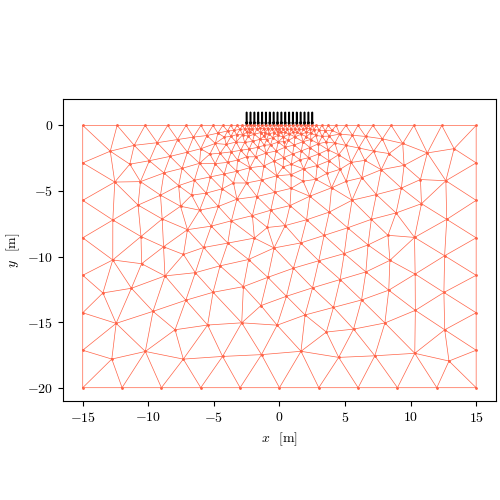

In [8]:
plot_mesh(nodes, elements, loads, figsize=[5, 5])

### Checking angles for the analytical solution

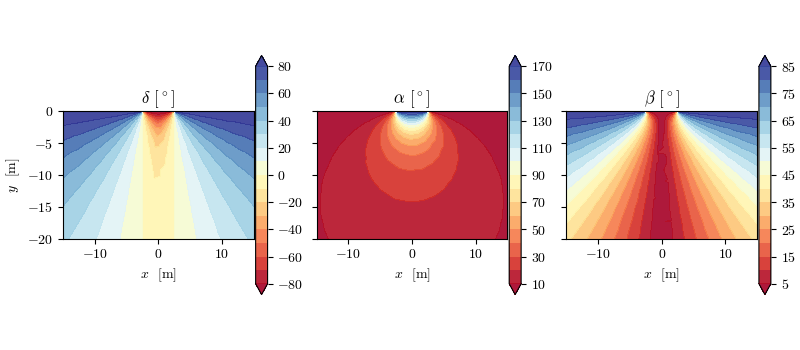

In [9]:
fields=(np.rad2deg(tensors_AS["delta"]), np.rad2deg(tensors_AS["alpha"]), np.rad2deg(tensors_AS["beta"]))
plot_fields(  # Stresses in yy-direction
    fields=fields, nodes=nodes, elements=elements,
    titles=["$\\delta$ [$^\circ$]", "$\\alpha$ [$^\circ$]", "$\\beta$ [$^\circ$]"],
    share_colorbar=False, figsize=[8, 3.5]
)

### Cartesian stresses

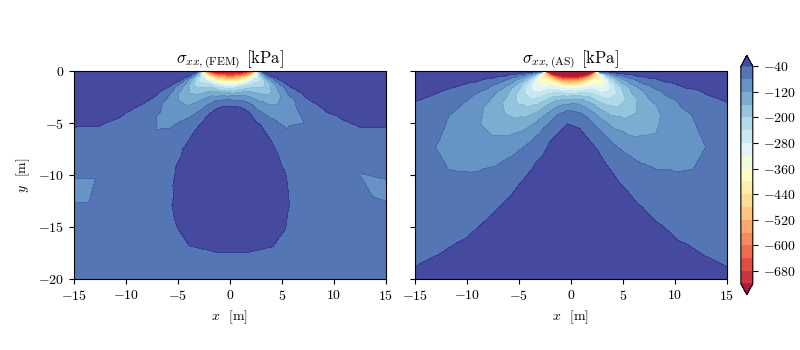

In [10]:
fields=[tensors_FEM["𝜎_xx"], tensors_AS["𝜎_xx"]]
plot_fields(  # Stresses in xx-direction
    fields=fields, nodes=nodes, elements=elements,
    titles=["$\sigma_{xx, \mathrm{(FEM)}}$ [kPa]", "$\sigma_{xx, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True, figsize=[8, 3.5], vmin=0.75*np.nanmin(fields)
)

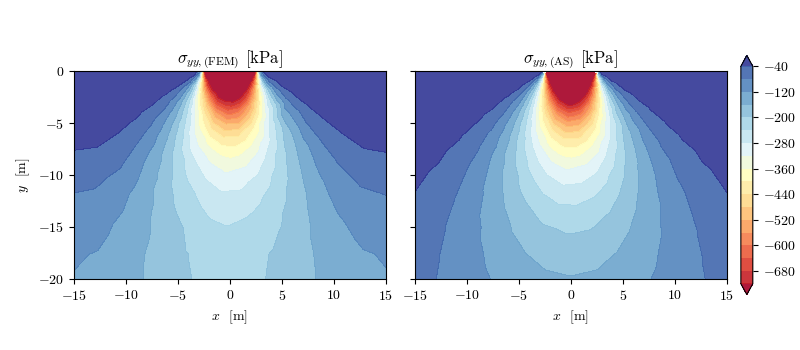

In [11]:
fields=(tensors_FEM["𝜎_yy"], tensors_AS["𝜎_yy"])
plot_fields(  # Stresses in yy-direction
    fields=fields, nodes=nodes, elements=elements,
    titles=["$\sigma_{yy, \mathrm{(FEM)}}$ [kPa]", "$\sigma_{yy, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True, figsize=[8, 3.5], vmin=0.75*np.nanmin(fields)
)

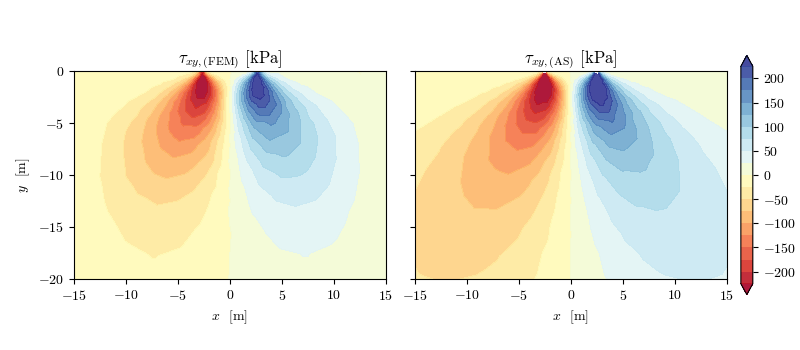

In [12]:
fields=(tensors_FEM["𝜏_xy"], tensors_AS["𝜏_xy"])
vmin=0.75*np.nanmin(fields)
vmax=0.75*np.nanmax(fields)

plot_fields(  # Stresses in xy-direction
    fields=(tensors_FEM["𝜏_xy"], tensors_AS["𝜏_xy"]),
    nodes=nodes, elements=elements,
    titles=["$\\tau_{xy, \mathrm{(FEM)}}$ [kPa]", "$\\tau_{xy, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True, figsize=[8, 3.5], vmin=vmin, vmax=vmax
)

### Principal stresses and directions

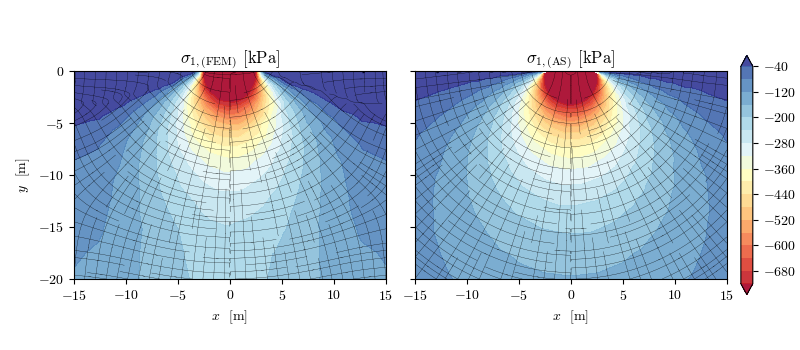

In [13]:
fields=(tensors_FEM["𝜎_1"], tensors_AS["𝜎_1"])
vmin = 0.75*np.nanmin(fields)
# Major principal stress
fig = plot_fields(
    fields=(tensors_FEM["𝜎_1"], tensors_AS["𝜎_1"]),
    nodes=nodes, elements=elements,
    titles=["$\sigma_{1, \mathrm{(FEM)}}$ [kPa]", "$\sigma_{1, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True,
    plot_eigenvalues=True,
    complete_tensors=(tensors_FEM, tensors_AS), figsize=[8, 3.5],
    vmin=vmin
)

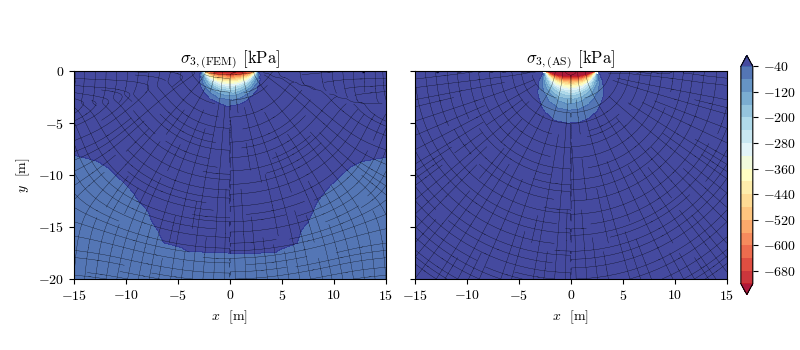

In [14]:
fields=(tensors_FEM["𝜎_3"], tensors_AS["𝜎_3"])
vmin = 0.75*np.nanmin(fields)
# Minor principal stress
fig = plot_fields(
    fields=(tensors_FEM["𝜎_3"], tensors_AS["𝜎_3"]),
    nodes=nodes, elements=elements,
    titles=["$\sigma_{3, \mathrm{(FEM)}}$ [kPa]", "$\sigma_{3, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True,
    plot_eigenvalues=True,
    complete_tensors=(tensors_FEM, tensors_AS), figsize=[8, 3.5],
    vmin=vmin
)

### Displacements (FEM solution)

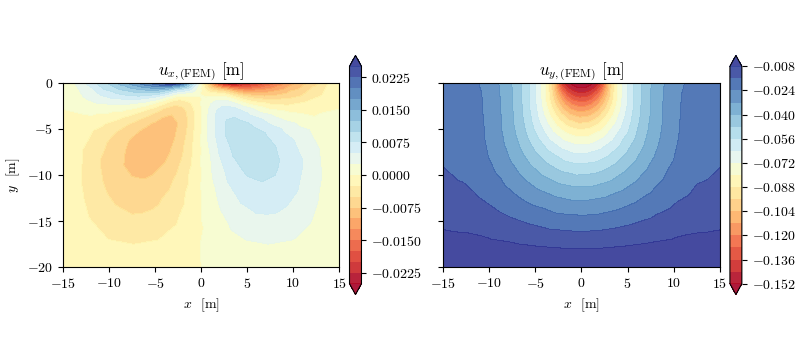

In [15]:
plot_fields(
    fields=(tensors_FEM["𝑢_x"], tensors_FEM["𝑢_y"]),
    nodes=nodes, elements=elements,
    titles=["$u_{x, \mathrm{(FEM)}}$ [m]", "$u_{y, \mathrm{(FEM)}}$ [m]"],
    share_colorbar=False, figsize=[8, 3.5]
)

### Deformations  (FEM solution)

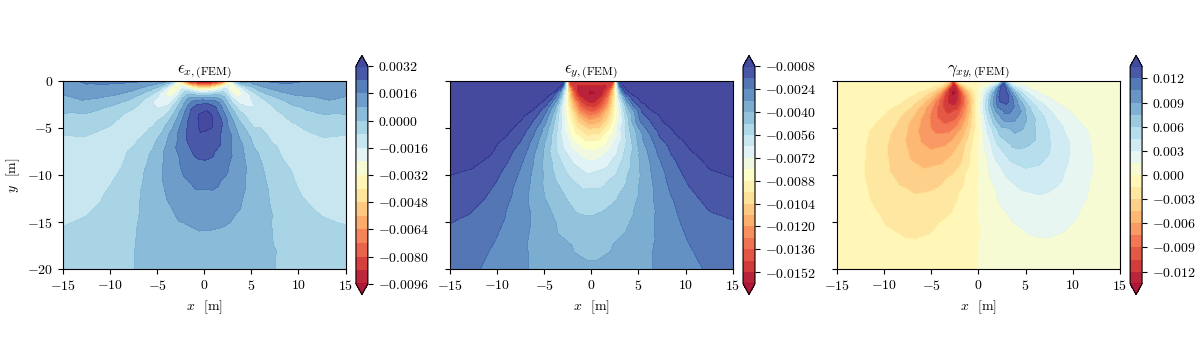

In [16]:
plot_fields(
    fields=(tensors_FEM["𝜀_xx"], tensors_FEM["𝜀_yy"], tensors_FEM["𝛾_xy"]),
    nodes=nodes, elements=elements,
    titles=["$\epsilon_{x, \mathrm{(FEM)}}$", "$\epsilon_{y, \mathrm{(FEM)}}$", "$\gamma_{xy, \mathrm{(FEM)}}$"],
    share_colorbar=False, figsize=[12, 3.5]
)

## FEM vs Analytical solutions

In [18]:
interact(  # Interactive widgets
    compare_solutions,
    x = widgets.BoundedFloatText(value=2, min=nodes[:, 1].min(), max=nodes[:, 1].max(), step=0.5, description='x [m]:'),
    y = widgets.BoundedFloatText(value=-3, min=nodes[:, 2].min(), max=-.005, step=0.5, description='y [m]'),
    field = widgets.Dropdown(options=tensors_FEM.keys(), value='𝜎_yy', description='Field:'),
    tensors_FEM=fixed(tensors_FEM),
    tensors_AS=fixed(tensors_AS),
    nodes=fixed(nodes),
    elements=fixed(elements),
);

interactive(children=(BoundedFloatText(value=2.0, description='x [m]:', max=15.0, min=-15.0, step=0.5), Bounde…